<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/aichi/aichi_patients_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pdfplumber

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 5.6MB 6.0MB/s 
     |████████████████████████████████| 143kB 40.3MB/s 
     |████████████████████████████████| 13.7MB 319kB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.25-cp36-none-any.whl size=31560 sha256=5c8eb58de5fbf19cd5578faeb591ad80d91931bcd909eaeaf2cde2750d6b52cc
  Stored in directory: /root/.cache/pip/wheels/fc/bd/c8/a28e0008387d034112de3c7c3bf6dbefa25653909a6269e4ff
Successfully built pdfplumber


In [2]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 4.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=565b845d9e21aca23daefe9e1de460a5b1403926228f06dd7445825bc172dd9f
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [3]:
import datetime
import pathlib
import re
from urllib.parse import urljoin

In [4]:
import pandas as pd
import pdfplumber
import requests
from bs4 import BeautifulSoup

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import japanize_matplotlib

In [6]:
from google.colab import files

In [7]:
aichi_citys = [
    "名古屋市",
    "一宮市",
    "瀬戸市",
    "春日井市",
    "犬山市",
    "江南市",
    "小牧市",
    "稲沢市",
    "尾張旭市",
    "岩倉市",
    "豊明市",
    "日進市",
    "清須市",
    "北名古屋市",
    "長久手市",
    "東郷町",
    "豊山町",
    "大口町",
    "扶桑町",
    "津島市",
    "愛西市",
    "弥富市",
    "あま市",
    "大治町",
    "蟹江町",
    "飛島村",
    "半田市",
    "常滑市",
    "東海市",
    "大府市",
    "知多市",
    "阿久比町",
    "東浦町",
    "南知多町",
    "美浜町",
    "武豊町",
    "岡崎市",
    "碧南市",
    "刈谷市",
    "豊田市",
    "安城市",
    "西尾市",
    "知立市",
    "高浜市",
    "みよし市",
    "幸田町",
    "豊橋市",
    "豊川市",
    "蒲郡市",
    "新城市",
    "田原市",
    "設楽町",
    "東栄町",
    "豊根村",
]

In [8]:
ages_list = [
    "10歳未満",
    "10代",
    "20代",
    "30代",
    "40代",
    "50代",
    "60代",
    "70代",
    "80代",
    "90代",
    "100代",
]

In [9]:
def fetch_file(url, dir="."):

    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [10]:
def days2date(s):

    y = 2021 if s.name > 16576 else 2020

    days = re.findall("[0-9]{1,2}", s["発表日"])

    if len(days) == 2:
        m, d = map(int, days)
        return pd.Timestamp(year=y, month=m, day=d)
    else:
        return pd.NaT

# スクレイピング

In [11]:
url = "https://www.pref.aichi.jp/site/covid19-aichi/"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7.0; rv:11.0) like Gecko"
}

In [12]:
JST = datetime.timezone(datetime.timedelta(hours=+9), "JST")
dt_now = datetime.datetime.now(JST)

In [13]:
r = requests.get(url, headers=headers)
r.raise_for_status()

soup = BeautifulSoup(r.content, "html.parser")

In [14]:
dfs = []

for tag in soup.find("span", text="▶ 愛知県内の発生事例").parent.find_all(
    "a", href=re.compile(".pdf$")
)[::-1]:

    link = urljoin(url, tag.get("href"))

    path_pdf = fetch_file(link)

    with pdfplumber.open(path_pdf) as pdf:

        for page in pdf.pages:

            table = page.extract_table()

            df_tmp = pd.DataFrame(table[1:], columns=table[0])

            dfs.append(df_tmp)

In [15]:
df = pd.concat(dfs).set_index("No")

# 前処理

In [16]:
# 発表日が欠損を削除
df.dropna(subset=["発表日"], inplace=True)

In [17]:
# Noでソート
df.index = df.index.astype(int)
df.sort_index(inplace=True)

In [18]:
# 発表日をdatetimeに変換
df["発表日"] = df.apply(days2date, axis=1)

In [19]:
cjk = str.maketrans("⻲⻑黑戶⻯⻄⻘⻤", "亀長黒戸竜西青鬼")

In [20]:
# 文字コード正規化
df["住居地"] = df["住居地"].str.normalize("NFKC")
df["住居地"] = df["住居地"].apply(lambda s: s.translate(cjk))

df["年代・性別"] = df["年代・性別"].str.normalize("NFKC")

In [21]:
# 年代と性別を分割
df_ages = df["年代・性別"].str.extract("(.+)(男性|女性|その他)").rename(columns={0: "年代", 1: "性別"})
df = df.join(df_ages)

In [22]:
# 前後の空白削除
df["年代"] = df["年代"].str.strip()

In [23]:
df.to_csv("aichi.csv", encoding="utf_8_sig")
# files.download("aichi.csv")

# 陽性者数

In [24]:
s = df["発表日"].value_counts().sort_index().asfreq("D", fill_value=0)

<BarContainer object of 345 artists>

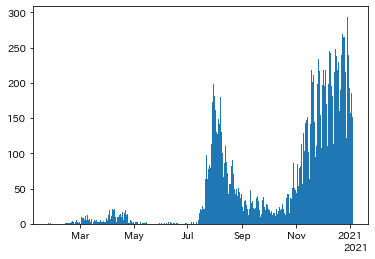

In [25]:
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
fig, ax = plt.subplots()

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.bar(s.index, s, width=1)

In [26]:
# 直近14日
s.tail(14)

2020-12-22    190
2020-12-23    239
2020-12-24    270
2020-12-25    265
2020-12-26    265
2020-12-27    216
2020-12-28    122
2020-12-29    235
2020-12-30    294
2020-12-31    239
2021-01-01    193
2021-01-02    158
2021-01-03    185
2021-01-04    152
Freq: D, Name: 発表日, dtype: int64

# 住所地

## 県内

In [27]:
df_kennai = df[df["住居地"].isin(aichi_citys)]

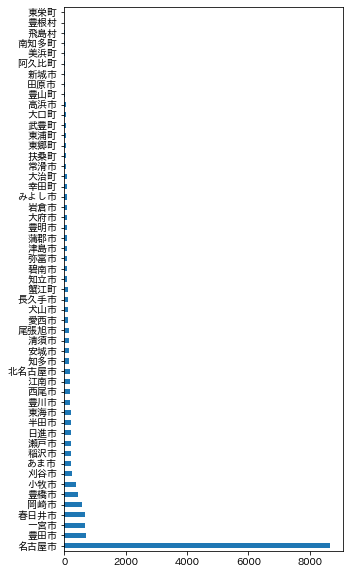

In [28]:
# 県内
df_kennai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [29]:
df_kennai["住居地"].value_counts()

名古屋市     8662
豊田市       703
一宮市       683
春日井市      666
岡崎市       573
豊橋市       465
小牧市       371
刈谷市       249
あま市       234
稲沢市       219
瀬戸市       218
日進市       217
半田市       217
東海市       213
豊川市       205
西尾市       196
江南市       184
北名古屋市     184
知多市       171
安城市       171
清須市       161
尾張旭市      156
愛西市       116
犬山市       112
長久手市      111
蟹江町       110
知立市        99
碧南市        99
弥富市        98
津島市        96
蒲郡市        93
豊明市        91
大府市        90
岩倉市        87
みよし市       86
幸田町        85
大治町        83
常滑市        71
扶桑町        67
東郷町        64
東浦町        59
武豊町        51
大口町        49
高浜市        44
豊山町        39
田原市        38
新城市        30
阿久比町       24
美浜町        24
南知多町       16
飛島村        12
豊根村         1
東栄町         1
Name: 住居地, dtype: int64

In [30]:
df_kennai.to_csv("kennai.csv", encoding="utf_8_sig")
# files.download("kennai.csv")

## 県外

In [31]:
df_kengai = df[~df["住居地"].isin(aichi_citys)]

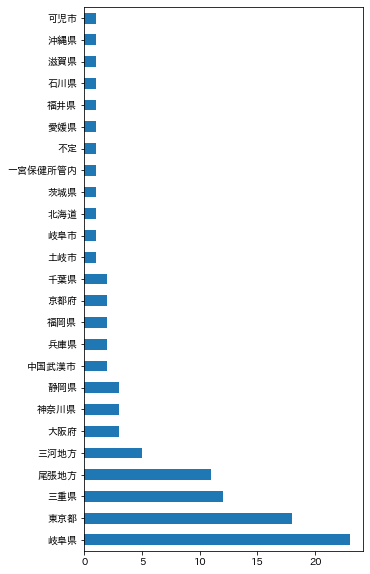

In [32]:
# 県外
df_kengai["住居地"].value_counts().plot.barh(figsize=(5, 10))

In [33]:
df_kengai["住居地"].value_counts()

岐阜県        23
東京都        18
三重県        12
尾張地方       11
三河地方        5
大阪府         3
神奈川県        3
静岡県         3
中国武漢市       2
兵庫県         2
福岡県         2
京都府         2
千葉県         2
土岐市         1
岐阜市         1
北海道         1
茨城県         1
一宮保健所管内     1
不定          1
愛媛県         1
福井県         1
石川県         1
滋賀県         1
沖縄県         1
可児市         1
Name: 住居地, dtype: int64

In [34]:
df_kengai.to_csv("kengai.csv", encoding="utf_8_sig")
# files.download("kengai.csv")

## 置換

In [35]:
# 県外に置換
df["住居地"] = df["住居地"].where(df["住居地"].isin(aichi_citys), "県外")

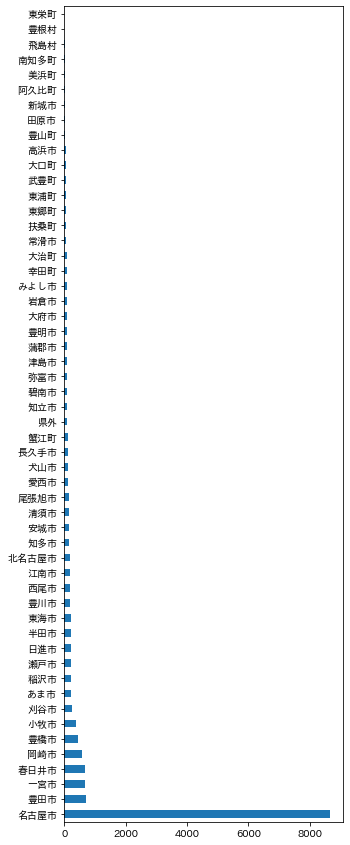

In [36]:
df["住居地"].value_counts().plot.barh(figsize=(5, 15))

In [37]:
df["住居地"].value_counts()

名古屋市     8662
豊田市       703
一宮市       683
春日井市      666
岡崎市       573
豊橋市       465
小牧市       371
刈谷市       249
あま市       234
稲沢市       219
瀬戸市       218
日進市       217
半田市       217
東海市       213
豊川市       205
西尾市       196
江南市       184
北名古屋市     184
知多市       171
安城市       171
清須市       161
尾張旭市      156
愛西市       116
犬山市       112
長久手市      111
蟹江町       110
県外        100
知立市        99
碧南市        99
弥富市        98
津島市        96
蒲郡市        93
豊明市        91
大府市        90
岩倉市        87
みよし市       86
幸田町        85
大治町        83
常滑市        71
扶桑町        67
東郷町        64
東浦町        59
武豊町        51
大口町        49
高浜市        44
豊山町        39
田原市        38
新城市        30
阿久比町       24
美浜町        24
南知多町       16
飛島村        12
豊根村         1
東栄町         1
Name: 住居地, dtype: int64

# 性別

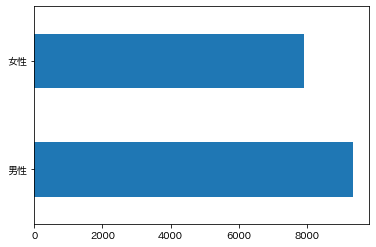

In [38]:
df["性別"].value_counts().plot.barh()

In [39]:
# 性別 欠損数
df["性別"].isna().sum()

0

In [40]:
# 性別
df["性別"].value_counts()

男性    9346
女性    7918
Name: 性別, dtype: int64

# 年代確認

## 置換前

In [41]:
# ユニーク確認
df["年代"].unique()

array(['40代', '60代', '50代', '80代', '70代', '20代', '30代', '90代', '10歳未満',
       '10代', '100代', '高齢者', 'ー代', '10歳未満代'], dtype=object)

In [42]:
df["年代"].value_counts()

20代       4231
30代       2564
40代       2454
50代       2242
60代       1457
70代       1429
10代       1147
80代        937
10歳未満      517
90代        274
100代         8
10歳未満代       2
ー代           1
高齢者          1
Name: 年代, dtype: int64

## 確認

In [43]:
# リスト外
df[~df["年代"].isin(ages_list)]

,発表日,年代・性別,国籍,住居地,接触状況,備考,年代,性別
No,,,,,,,,
5543,2020-10-11,高齢者女性,,名古屋市,,名古屋市発表2999,高齢者,女性
13890,2020-12-19,ー代女性,,豊橋市,,豊橋市発表347,ー代,女性
17216,2021-01-04,10歳未満代男性,,名古屋市,No.16874と接触,名古屋市発表8646,10歳未満代,男性
17235,2021-01-04,10歳未満代女性,,名古屋市,No.15636と接触,名古屋市発表8665,10歳未満代,女性


## 置換後 

In [44]:
# 10歳未満代を10歳未満に置換
df["年代"] = df["年代"].replace("10歳未満代", "10歳未満")

In [45]:
# リスト外をその他に置換
df["年代"] = df["年代"].where(df["年代"].isin(ages_list), "その他")

In [46]:
df["年代"].unique()

array(['40代', '60代', '50代', '80代', '70代', '20代', '30代', '90代', '10歳未満',
       '10代', '100代', 'その他'], dtype=object)

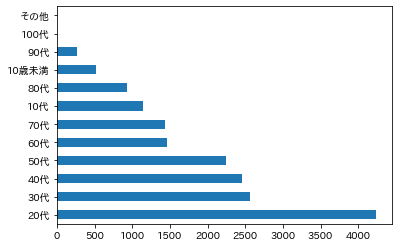

In [47]:
df["年代"].value_counts().plot.barh()

In [48]:
df["年代"].value_counts()

20代      4231
30代      2564
40代      2454
50代      2242
60代      1457
70代      1429
10代      1147
80代       937
10歳未満     519
90代       274
100代        8
その他         2
Name: 年代, dtype: int64